In [1]:
#!/home/jmframe/programs/anaconda3/bin/python3
# jmframe: I am making this script to loop through 
# the nwm land ponding/depth2watertable file (RT)
# and isolate the values within a shapefile. 
# Save their mean values for LSTM

In [2]:
import datetime
import geopandas as gpd 
import matplotlib.pyplot as plt 
import netCDF4 as nc
import numpy as np
import os
from osgeo import gdal
import pandas as pd
import pickle
import random
import rioxarray
import shapely
from shapely.geometry import Polygon, Point, MultiPolygon
import shapefile
import sys 
import time
import tools
import xarray as xr

#For parallel implimentation
from joblib import Parallel, delayed
import multiprocessing

In [3]:
# Open attributes.
openthis = '/home/NearingLab/data/camels_attributes_v2.0/camels_all.txt'
area_index='area_geospa_fabric'
attributes = pd.read_csv(openthis, sep=';', index_col='gauge_id')
# Add the basin ID as a 8 element string with a leading zero if neccessary
basin_id_str = []
for a in attributes.index.values:
    basin_id_str.append(str(a).zfill(8))
attributes['basin_id_str'] = basin_id_str

In [4]:
# locate the data
dataName = 'camels_all.csv'
#VdataLoc = dataDir + dataName
# load the data with pandas
pd_camatt = pd.read_csv(dataName, sep=',', index_col='gauge_id')

In [5]:
# import shapefile using geopandas
# Comes in with spatial reference 4269
gpd_camels = gpd.read_file('camels_shapes/HCDN_nhru_final_671.shp')
pd_camels = pd.DataFrame(gpd_camels)
pd_camels.set_index('hru_id', inplace=True, drop=True)

In [6]:
# Example file to get the lat/lons for the camels basins
fname = '/home/NearingLab/data/nwm/v2/RT/200010230900.RTOUT_DOMAIN1.comp'
gname = 'Fulldom_hires_netcdf_250m.nc'

In [7]:
# Get the info in numpy array. Especially the lat,lon, which will be transformed
np_rt = tools.LoadRT(fname)
# Example file with data
nc_rt = nc.Dataset(fname)
# Example file to get the lat/lons for the camels basins
nc_geo_em = nc.Dataset(gname)

In [8]:
nc_geo_em

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4_CLASSIC data model, file format HDF5):
    Conventions: CF-1.5
    Source_Software: WRF-Hydro GIS Pre-processor v5 (03/2018)
    history: Tue Jan 16 08:46:51 2018: ncap2 -O -s RETDEPRTFAC=RETDEPRTFAC*0.0+1.0 Fulldom_hires_netcdf_file_250m_NWMv1.2_DEFAULT.nc Fulldom_hires_netcdf_file_250m_NWMv1.2_DEFAULT.nc
Tue Jan 16 08:44:50 2018: ncap2 -s LKSATFAC=LKSATFAC*0.0+1000.0 Fulldom_hires_netcdf_file_250m_NWMv1.2_calib2_ADJFL.nc Fulldom_hires_netcdf_file_250m_NWMv1.2_DEFAULT.nc
Mon Mar 27 18:43:54 2017: ncap2 -O -s RETDEPRTFAC=1.0 Fulldom_hires_netcdf_file_250m_NWMv1.2_calib1.nc Fulldom_hires_netcdf_file_250m_NWMv1.2_calib1.nc
Mon Mar 27 18:43:17 2017: ncap2 -O -s LKSATFAC=1000.0 Fulldom_hires_netcdf_file_250m_NWMv1.2_calib1.nc Fulldom_hires_netcdf_file_250m_NWMv1.2_calib1.nc
Thu Mar 23 21:23:47 2017: ncks -A -v STREAMORDER KS_FILES/Harmonized_DEM_2/STREAMORDER.nc Fulldom_hires_netcdf_file_250m_NWMv1.2_harmdem.nc
Thu Mar 23 21:21:09 2017

In [9]:
# Get the latitude and longitudes
glat = nc_geo_em['LATITUDE']
glon = nc_geo_em['LONGITUDE']

In [10]:
# Names of the features in this dataset.
featNam = ['zwattablrt','sfcheadsubrt']

In [11]:
# find nearest cells to camels shapefiles
cam_grid_i = {}
cam_grid_v = {}
if False:
    for cam in list(pd_camels.index.values):
        clat = pd_camatt.loc[cam, 'gauge_lat']
        clon = pd_camatt.loc[cam, 'gauge_lon']
        A = np.array(np.sqrt(np.square((glat-clat))+np.square((glon-clon))))
        imin=np.where(A == np.amin(A))
        minlat = imin[0]
        minlon = imin[1]
        cam_grid_i[cam] = [minlat[0],minlon[0]]
        cam_grid_v[cam] = [glat[minlat,minlon][0],glon[minlat,minlon][0]]
        with open('camels_grid_250m_indices.p', 'wb') as handle:
            pickle.dump(cam_grid_i, handle, protocol=pickle.HIGHEST_PROTOCOL)
        with open('camels_grid_250m_values.p', 'wb') as handle:
            pickle.dump(cam_grid_v, handle, protocol=pickle.HIGHEST_PROTOCOL)
else:
    with open('camels_grid_250m_indices.p', 'rb') as pf:
        cam_grid_i = pickle.load(pf)
    with open('camels_grid_250m_values.p', 'rb') as pf:
        cam_grid_v = pickle.load(pf)

In [12]:
# Some of the basin shapefiles are multi polygons. 
# But when that is the case there is one polygone for the vast majority of the basin.
# So in this loop I am going to identify, when it is a multi polygon, 
# which has the most points.
# Main polygon Index:
mpindx = {new_list: np.nan for new_list in pd_camels.index.values}
# Loop though basins and find the polygon with the largest number of coordinants
for cam in pd_camels.index.values:
    # Should take when multipolygons come up
    try:
        nshapes=len(gpd_camels.loc[cam].geometry)
        max_n = 0
        for j in range(0,nshapes+1):
            npoints = len(gpd_camels.loc[cam].geometry[j].exterior.coords.xy[0])
            if npoints > max_n:
                max_n = npoints
                mpindx[cam] = j
    # This is a single polygone, so there is no need to find the max number of points.
    except:
        pass

In [13]:
# Make a list of the bounding latitude and longitudes
cambnd ={new_list : [] for new_list in pd_camels.index.values}
for cam in list(pd_camels.index.values):
    cambnd[cam] = pd_camels.loc[cam,'geometry'].bounds

In [14]:
def locate_cells_within_basin(i):
    cam = pd_camels.index.values[i]
    if len(ncpindx[cam]) > 0:
        return
    xy_list = []
    ix = cam_grid_i[cam][1]
    iy = cam_grid_i[cam][0]
#    print(cam, glon[iy,ix], glat[iy,ix])
    
    # going donw in index goes up in latitude
    for iup in reversed(range(0,iy)):
        llat = glat[iup,ix].data+0
        if llat > cambnd[cam][3]:
            maxilat = iup-1
            break

    # going up in index is going down in latitude
    for idown in range(iy,glat.shape[0]):
        llat = glat[idown,ix].data+0
        if llat < cambnd[cam][1]:
            minilat = idown+1
            break

    # Going up in index is going up in longitude
    for iright in range(ix, glon.shape[1]):
        llon = glon[iy,iright].data+0
        if llon > cambnd[cam][2]:
            maxilon = iright+1
            break

    # Going down in index is going down in longitude
    for ileft in reversed(range(0,ix)):
        llon = glon[iy,ileft].data+0
        if llon < cambnd[cam][0]:
            minilon = ileft-1
            break

#    print('maxilat = {}, minilat = {}, maxilon = {}, minilon = {}'.format(maxilat,minilat,maxilon,minilon))
#    print('max lat = {:.4f}, min lat = {:.4f}, max lon = {:.4f}, min lon = {:.4f}'.format(glat[maxilat,ix],
#                                                glat[minilat,ix],glon[iy,maxilon],glon[iy,minilon]))
#    print('total number of cells to test = {}'.format((minilat-maxilat) * (maxilon-minilon)))
    
    # Now that we have a rough range of cells for each basin, 
    # test all of those for being within the shapefile.
    for y in range(maxilat,minilat):
        for x in range(minilon,maxilon):
            llon = glon[y,x]
            llat = glat[y,x]
            # If the example value is null, then don't do anything and continue loop
            if nc_geo_em['TOPOGRAPHY'][y,x].mask:
                pass
            else:
                point = Point([llon,llat])
                if mpindx[cam] >= 0: # For a multi-array. 
                    #Use array with most point
                    if gpd_camels.loc[cam].geometry[mpindx[cam]].contains(point):
                        xy_list.append([x,y])
                else:
                    if gpd_camels.loc[cam].geometry.contains(point):
                        xy_list.append([x,y])
    ncpindx[cam] = xy_list

In [15]:
num_cores = multiprocessing.cpu_count()
print(f"There are {num_cores} cores available")

There are 16 cores available


In [16]:
# point indicess in Camels Basins
ncpindx = {new_list : [] for new_list in pd_camels.index.values}

In [17]:
pd_camels.index.values.shape[0]

671

In [18]:
# Here I am going to try to loop through each camels basin, \
# then check all the cells within the bounds.
r = list(range(pd_camels.index.values.shape[0]))
random.shuffle(r)
if False:
#     for cam in list(pd_camels.index.values):
#         ncpindx[cam].append(locate_cells_within_basin(cam))
    result_cams = Parallel(n_jobs=num_cores, prefer="threads") \
    (delayed(locate_cells_within_basin)(i) for i in r)
    
#     with open('nc_camels_locs_cam250m.p', 'wb') as pf:
#         pickle.dump(ncpindx, pf, protocol=pickle.HIGHEST_PROTOCOL)
else:
    with open('nc_camels_locs_cam250m.p', 'rb') as pf:
        ncpindx = pickle.load(pf)

In [19]:
count=0
for cam in pd_camels.index.values:
    if len(ncpindx[cam]) > 0:
        count+=1
        grid_area = len(ncpindx[cam])*250**2/1000/1000
        basin_area = attributes.loc[cam, 'area_geospa_fabric']
        print(count, cam, '{:.1f}'.format(100*(basin_area - grid_area)/basin_area))

1 1013500 9.4
2 1022500 17.3
3 1030500 23.0
4 1031500 18.0
5 1047000 9.7
6 1052500 9.8
7 1054200 12.8
8 1055000 9.2
9 1057000 14.9
10 1073000 8.7
11 1078000 7.5
12 1118300 6.5
13 1121000 8.9
14 1123000 29.3
15 1134500 7.2
16 1137500 28.7
17 1139000 8.2
18 1139800 10.0
19 1142500 18.7
20 1144000 12.6
21 1162500 12.3
22 1169000 14.6
23 1170100 14.0
24 1181000 10.1
25 1187300 8.5
26 1195100 10.3
27 1333000 11.0
28 1350000 9.8
29 1350080 6.8
30 1350140 10.7
31 1365000 9.1
32 1411300 6.5
33 1413500 7.7
34 1414500 8.7
35 1415000 16.6
36 1423000 13.5
37 1434025 10.4
38 1435000 7.0
39 1439500 10.8
40 1440000 12.3
41 1440400 9.0
42 1451800 7.1
43 1466500 8.0
44 1484100 6.8
45 1485500 5.7
46 1486000 6.2
47 1487000 7.4
48 1491000 6.6
49 1510000 10.0
50 1516500 6.3
51 1518862 8.4
52 1532000 14.0
53 1539000 10.2
54 1542810 8.0
55 1543000 9.5
56 1543500 11.7
57 1544500 13.3
58 1545600 10.1
59 1547700 17.2
60 1548500 8.7
61 1549500 8.9
62 1550000 9.4
63 1552000 12.6
64 1552500 6.9
65 1557500 8.0
66 1

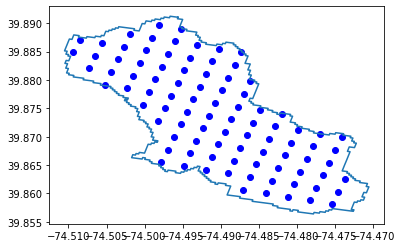

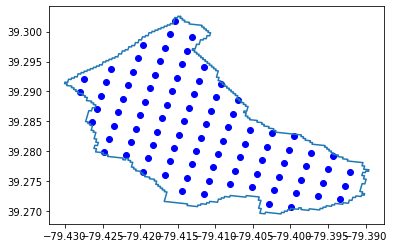

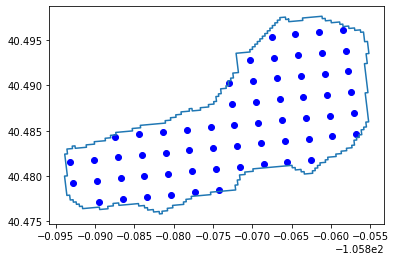

In [20]:
for cam in pd_camels.index.values:
    if len(ncpindx[cam]) > 100:
        continue
    
    x_point=[]
    y_point=[]

    for i in range(len(ncpindx[cam])):
        x_point.append(glon[ncpindx[cam][i][1], ncpindx[cam][i][0]])
        y_point.append(glat[ncpindx[cam][i][1], ncpindx[cam][i][0]])

    if mpindx[cam] >= 0:
        x_poly,y_poly = gpd_camels.loc[cam].geometry[mpindx[cam]].exterior.xy
    else:
        x_poly,y_poly = gpd_camels.loc[cam].geometry.exterior.xy

    fig, ax = plt.subplots()
    ax.plot(x_poly,y_poly)
    ax.scatter(x_point,y_point, c='b')
    plt.show()
    plt.close()

In [21]:
# Parallel example
dumbdict={i**2:[] for i in range(10)}
def sqrt(val):
    dumbdict[val]=np.sqrt(val)
    #return np.sqrt(val)
Parallel(n_jobs=9, prefer="threads")(delayed(sqrt)(i ** 2) for i in range(10))
print(dumbdict)

{0: 0.0, 1: 1.0, 4: 2.0, 9: 3.0, 16: 4.0, 25: 5.0, 36: 6.0, 49: 7.0, 64: 8.0, 81: 9.0}


In [22]:
 fname = tools.construct_RT_name_v2(1996,1,2,21)

In [23]:
np_ldas = tools.LoadRT(fname)

In [24]:
np_ldas.shape

(2, 1, 15360, 18432)

In [25]:
for cam in pd_camels.index.values:
    grdX = np.array(ncpindx[cam])[:,1]
    grdY = np.array(ncpindx[cam])[:,0]
    print(cam, np.nanmean(np_ldas[:,0,grdX,grdY], axis=1), np.nanmax(np_ldas[:,0,grdX,grdY], axis=1))

1013500 [0.         2.00000003] [0.         2.00000003]
1022500 [0.         2.00000003] [0.         2.00000003]
1030500 [0.         2.00000003] [0.         2.00000003]
1031500 [0.         2.00000003] [0.         2.00000003]
1047000 [0.         2.00000003] [0.         2.00000003]
1052500 [0.         2.00000003] [0.         2.00000003]
1054200 [0.         2.00000003] [0.         2.00000003]
1055000 [0.         2.00000003] [0.         2.00000003]
1057000 [0.         2.00000003] [0.         2.00000003]
1073000 [0.         2.00000003] [0.         2.00000003]
1078000 [0.         2.00000003] [0.         2.00000003]
1118300 [0.         2.00000003] [0.         2.00000003]
1121000 [0.         2.00000003] [0.         2.00000003]
1123000 [0.         2.00000003] [0.         2.00000003]
1134500 [0.         2.00000003] [0.         2.00000003]
1137500 [0.         2.00000003] [0.         2.00000003]
1139000 [0.         2.00000003] [0.         2.00000003]
1139800 [0.         2.00000003] [0.         2.00

2315500 [0.         1.97116483] [0.         2.00000003]
2324400 [0.         1.99397412] [0.         2.00000003]
2327100 [0.         2.00000003] [0.         2.00000003]
2342933 [0.         2.00000003] [0.         2.00000003]
2349900 [0.         1.74979341] [0.         2.00000003]
2350900 [4.53537593e-04 1.94333303e+00] [3.         2.00000003]
2361000 [0.         1.99996404] [0.         2.00000003]
2363000 [0.        1.9996019] [0.         2.00000003]
2369800 [0.        1.9406327] [0.         2.00000003]
2371500 [0.         1.99766782] [0.         2.00000003]
2372250 [0.         1.99556755] [0.         2.00000003]
2374500 [0.        1.9557942] [0.         2.00000003]
2381600 [0.         2.00000003] [0.         2.00000003]
2384540 [0.01734104 1.63034685] [4.         2.00000003]
2395120 [0.         2.00000003] [0.         2.00000003]
2408540 [1.50559895e-03 1.96939873e+00] [4.         2.00000003]
2415000 [7.86472670e-04 1.95899859e+00] [1.         2.00000003]
2422500 [0.12241361 1.18927529

5495000 [6.49182031e-04 1.71445082e+00] [3.         2.00000003]
5495500 [3.01318267e-04 1.56349532e+00] [1.         2.00000003]
5501000 [0.00859845 1.17488537] [3.         2.00000003]
5503800 [0.00250156 1.20916199] [1.         2.00000003]
5507600 [0.14626506 0.61963856] [18.          2.00000003]
5508805 [0.05902087 0.93655568] [22.          2.00000003]
5514500 [0.07907988 0.89910851] [37.          2.00000003]
5525500 [0.08781636 1.14037671] [60.          2.00000003]
5556500 [0.22116416 0.94625806] [38.          2.00000003]
5584500 [7.78119286e-05 1.72841305e+00] [1.         2.00000003]
5585000 [3.57142857e-04 1.66011312e+00] [3.         2.00000003]
5591550 [0.         2.00000003] [0.         2.00000003]
5592050 [0.         2.00000003] [0.         2.00000003]
5592575 [0.         2.00000003] [0.         2.00000003]
5593575 [0.         2.00000003] [0.         2.00000003]
5593900 [0.         2.00000003] [0.         2.00000003]
5595730 [0.         2.00000003] [0.         2.00000003]
603750

8178880 [0.         2.00000003] [0.         2.00000003]
8189500 [0.         2.00000003] [0.         2.00000003]
8190000 [0.         2.00000003] [0.         2.00000003]
8190500 [0.         2.00000003] [0.         2.00000003]
8194200 [0.         1.99995044] [0.         2.00000003]
8195000 [0.         2.00000003] [0.         2.00000003]
8196000 [0.         2.00000003] [0.         2.00000003]
8198500 [0.         2.00000003] [0.         2.00000003]
8200000 [0.         2.00000003] [0.         2.00000003]
8202700 [0.         2.00000003] [0.         2.00000003]
8267500 [0.0020339  1.65071189] [1.         2.00000003]
8269000 [0.03659027 1.47382391] [14.          2.00000003]
8271000 [0.         1.65007156] [0.         2.00000003]
8324000 [0.         1.99346479] [0.         2.00000003]
8377900 [1.44787645e-03 1.76930505e+00] [2.         2.00000003]
8378500 [1.34649910e-03 1.74878818e+00] [5.         2.00000003]
8380500 [0.         1.91530581] [0.         2.00000003]
9034900 [0.         1.88602487

12414500 [0.         1.99537335] [0.         2.00000003]
12447390 [0.         2.00000003] [0.         2.00000003]
12451000 [0.         2.00000003] [0.         2.00000003]
12488500 [0.         2.00000003] [0.         2.00000003]
13011500 [0.         1.98481973] [0.         2.00000003]
13011900 [0.         1.96071403] [0.         2.00000003]
13018300 [0.         1.97632853] [0.         2.00000003]
13023000 [2.90124173e-04 1.93157134e+00] [2.         2.00000003]
13083000 [0.         1.90278193] [0.         2.00000003]
13161500 [0.        1.9904846] [0.         2.00000003]
13235000 [0.         1.98115301] [0.         2.00000003]
13240000 [0.         1.94254057] [0.         2.00000003]
13310700 [0.         1.96604249] [0.         2.00000003]
13313000 [0.         1.97342422] [0.         2.00000003]
13331500 [0.         1.87377391] [0.         2.00000003]
13337000 [4.60893211e-05 1.98901694e+00] [1.         2.00000003]
13338500 [0.         1.95900654] [0.         2.00000003]
13340000 [9.24965

In [27]:
#Start year
s_y = 1993
pd_s_y = str(int(s_y))+'-01-01 00:00'
#End year
pd_e_y = str(int(s_y)+1)+'-01-01 00:00'

# Load Gauge IDs
basin_file = "basin_list.txt"
with open(basin_file, 'r') as fp:
    basins = fp.readlines()
    basins = [basin.strip() for basin in basins]

nBasins = len(basins)

# Names of the features in this dataset.
features = ['sfcheadsubrt','zwattablrt']

nFeatures = len(features)

# initialize time index
dates = pd.date_range(pd_s_y, pd_e_y, freq="180min")

nTimes = len(dates)


In [36]:
def collect_single_timestep(date):#, basins, ncpindx, features):

    # get file name
    fname = tools.construct_RT_name_v2(date.year,
                                         date.month,
                                         date.day,
                                         date.hour)
    print(fname)

    # init storage
    timestep_data_np = np.full([len(basins), len(features)*2], np.nan)    
    
    # check that there is a matching file.
    pe = os.path.exists(fname)
    
    # If there is a matching file, then open it up
    if pe: 

        # benchmarking
        t1 = time.time()
    
        # load netcdf file
        try:
            np_ldas = tools.LoadRT(fname)
            t2 = time.time()
            print('Time to load data', t2-t1) 
    
            # Getting the values by SLICING THE CAMELS BASINS, the features and the coords
            for ib, b in enumerate(basins):
                grdX = np.array(ncpindx[int(b)])[:,1]
                grdY = np.array(ncpindx[int(b)])[:,0]
                timestep_data_np[ib,0:2] = np.nanmean(np_ldas[:,0,grdX,grdY], axis=1)
                timestep_data_np[ib,2:4] = np.nanmax(np_ldas[:,0,grdX,grdY], axis=1)
#                 try:
#                     timestep_data_np[ib,0:2] = np.nanmean(np_ldas[:,0,grdX,grdY], axis=1)
#                 except: 
#                     timestep_data_np[ib,0:2] = np.nan
#                 try:
#                     timestep_data_np[ib,2:4] = np.nanmax(np_ldas[:,0,grdX,grdY], axis=1)
#                 except: 
#                     timestep_data_np[ib,2:4] = np.nan
            t3 = time.time()
            print('Time to extract data', t3-t2)
        except: 
            print('failed to open file: ', fname)
    else:
        print('failed to open file: ', fname)
    return timestep_data_np


In [ ]:
num_cores = multiprocessing.cpu_count()
print(f"There are {num_cores} cores available")

# Run the data collation in parallel
#results_parallel = Parallel(n_jobs=num_cores, prefer="threads")(delayed(collect_single_timestep)(dates[t]) for t in range(nTimes))
results_parallel = Parallel(n_jobs=num_cores, prefer="threads")(delayed(collect_single_timestep)(dates[t]) for t in range(16))

column_features=['mean_sfcheadsubrt','mean_zwattablrt','max_sfcheadsubrt','max_zwattablrt']

def make_dictionary(dates,features,basins):
    # Initialize space to save data
    camels_dictionary = {}
    # Creating pandas data frame
    # Initialize the data frame with all the dynamic features
    for b in basins:
        camels_dictionary[b] = pd.DataFrame(index=dates[0:16], columns=features)
    return camels_dictionary
camels_dictionary = make_dictionary(dates,column_features,basins)

In [41]:
for ib, b in enumerate(basins):
    camels_dictionary[b].loc[:] = np.array(results_parallel)[:,ib,:]

In [38]:
camels_dictionary

{'01022500':                      mean_sfcheadsubrt  mean_zwattablrt  max_sfcheadsubrt  \
 1993-01-01 00:00:00                0.0              2.0               0.0   
 1993-01-01 03:00:00                0.0              2.0               0.0   
 1993-01-01 06:00:00                0.0              2.0               0.0   
 1993-01-01 09:00:00                0.0              2.0               0.0   
 1993-01-01 12:00:00                0.0              2.0               0.0   
 1993-01-01 15:00:00                0.0              2.0               0.0   
 1993-01-01 18:00:00                0.0              2.0               0.0   
 1993-01-01 21:00:00                0.0              2.0               0.0   
 1993-01-02 00:00:00                0.0              2.0               0.0   
 1993-01-02 03:00:00                0.0              2.0               0.0   
 1993-01-02 06:00:00                0.0              2.0               0.0   
 1993-01-02 09:00:00                0.0             

In [61]:
with open('/home/NearingLab/data/nwm/v2/RT/camels_basins/dynamic_features_nwm_RT_1994.p',
          'rb') as pf: 
    rt_1994 = pickle.load(pf)

In [62]:
rt_1994[b]

,mean_sfcheadsubrt,mean_zwattablrt,max_sfcheadsubrt,max_zwattablrt
1994-01-01 00:00:00,0.0,2.0,0.0,2.0
1994-01-01 03:00:00,0.0,2.0,0.0,2.0
1994-01-01 06:00:00,0.0,2.0,0.0,2.0
1994-01-01 09:00:00,0.0,2.0,0.0,2.0
1994-01-01 12:00:00,0.0,2.0,0.0,2.0
...,...,...,...,...
1994-12-31 12:00:00,0.0,2.0,0.0,2.0
1994-12-31 15:00:00,0.0,2.0,0.0,2.0
1994-12-31 18:00:00,0.0,2.0,0.0,2.0
1994-12-31 21:00:00,0.0,2.0,0.0,2.0


In [77]:
for b in [basins[0]]:
    for itime in rt_1994[b].index.values:
        rt_1994[b]["day_of_year"].loc[itime] = pd.to_datetime(itime).timetuple().tm_yday
for b in basins:
    rt_1994[b]["day_of_year"] = rt_1994[basins[0]]["day_of_year"]
#    rt_1994[b][day] = rt_1994[b]

/home/jmframe/programs/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [80]:
rt_1994[b]

,mean_sfcheadsubrt,mean_zwattablrt,max_sfcheadsubrt,max_zwattablrt,day_of_year
1994-01-01 00:00:00,0.0,2.0,0.0,2.0,1
1994-01-01 03:00:00,0.0,2.0,0.0,2.0,1
1994-01-01 06:00:00,0.0,2.0,0.0,2.0,1
1994-01-01 09:00:00,0.0,2.0,0.0,2.0,1
1994-01-01 12:00:00,0.0,2.0,0.0,2.0,1
...,...,...,...,...,...
1994-12-31 12:00:00,0.0,2.0,0.0,2.0,365
1994-12-31 15:00:00,0.0,2.0,0.0,2.0,365
1994-12-31 18:00:00,0.0,2.0,0.0,2.0,365
1994-12-31 21:00:00,0.0,2.0,0.0,2.0,365


In [79]:
for b in basins:
    rt_1994[b].groupby("day_of_year").mean()

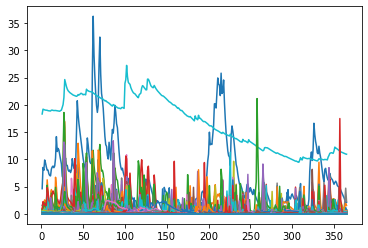

In [85]:
for b in basins:
    plt.plot(rt_1994[b].groupby("day_of_year").mean()['mean_sfcheadsubrt'])